## Soil Type Prediction Model

In [1]:
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy import stats
import joblib

In [2]:
# Function to categorize soil types
def categorize_soil_type(soil_type):
    if 'Clay' in soil_type or 'Black' in soil_type or 'Regur' in soil_type or 'Inceptisols' in soil_type or 'Mountain' in soil_type:
        return 'Clay soil'
    elif 'Sandy' in soil_type or 'Desert' in soil_type:
        return 'Sandy soil'
    elif 'Loamy' in soil_type or 'Alluvial' in soil_type or 'Red' in soil_type or 'Laterite' in soil_type or 'Delta' in soil_type:
        return 'Loamy soil'
    else:
        return 'Other'

In [3]:
soil_df = pd.read_csv('../data/crop_data.csv')
print(soil_df.columns)
soil_df = soil_df.dropna()
soil_df

Index(['STATE', 'SOIL_TYPE', 'N_SOIL', 'P_SOIL', 'K_SOIL', 'TEMPERATURE',
       'HUMIDITY', 'ph', 'RAINFALL', 'CROP_PRICE', 'CROP'],
      dtype='object')


,STATE,SOIL_TYPE,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,ph,RAINFALL,CROP_PRICE,CROP
0,Andaman and Nicobar,Sandy soil,90,42,43,20.879744,82.002744,6.502985,202.935536,7000,Amaranthus
1,Andaman and Nicobar,Sandy soil,85,58,41,21.770462,80.319644,7.038096,226.655537,5000,Green Banana
2,Andaman and Nicobar,Sandy soil,60,55,44,23.004459,82.320763,7.840207,263.964248,7000,Ladies Finger
3,Andaman and Nicobar,Sandy soil,74,35,40,26.491096,80.158363,6.980401,242.864034,7000,Bitter Gourd
4,Andaman and Nicobar,Sandy soil,78,42,42,20.130175,81.604873,7.628473,262.717340,120000,Black pepper
...,...,...,...,...,...,...,...,...,...,...,...
2195,West Bengal,Alluvial soil,107,34,32,26.774637,66.413269,6.780064,177.774507,1000,Onion
2196,West Bengal,Alluvial soil,99,15,27,27.417112,56.636362,6.086922,127.924610,800,Papaya
2197,West Bengal,Alluvial soil,118,33,30,24.131797,67.225123,6.362608,173.322839,560,Potato
2198,West Bengal,Alluvial soil,117,32,34,26.272418,52.127394,6.758793,127.175293,1500,Pumpkin


In [4]:
soil_df['GENERAL_SOIL_TYPE'] = soil_df['SOIL_TYPE'].apply(categorize_soil_type)
X = soil_df[['GENERAL_SOIL_TYPE', 'N_SOIL', 'P_SOIL', 'K_SOIL', 'TEMPERATURE',
       'HUMIDITY', 'RAINFALL']]

y = X.pop('GENERAL_SOIL_TYPE')
# encoder = LabelEncoder()
# y = encoder.fit_transform(y)
print(y.unique())
X

['Sandy soil' 'Loamy soil' 'Clay soil']


,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,RAINFALL
0,90,42,43,20.879744,82.002744,202.935536
1,85,58,41,21.770462,80.319644,226.655537
2,60,55,44,23.004459,82.320763,263.964248
3,74,35,40,26.491096,80.158363,242.864034
4,78,42,42,20.130175,81.604873,262.717340
...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,177.774507
2196,99,15,27,27.417112,56.636362,127.924610
2197,118,33,30,24.131797,67.225123,173.322839
2198,117,32,34,26.272418,52.127394,127.175293


In [20]:
[y.unique()]
y.value_counts()

GENERAL_SOIL_TYPE
Loamy soil    1143
Clay soil      564
Sandy soil     493
Name: count, dtype: int64

In [5]:
soil_df[soil_df['GENERAL_SOIL_TYPE'] == 'Clay soil']

,STATE,SOIL_TYPE,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,ph,RAINFALL,CROP_PRICE,CROP,GENERAL_SOIL_TYPE
80,Chattisgarh,Clayey soils,68,57,43,26.088679,80.379799,5.706943,182.904350,4200,Dry Chillies,Clay soil
81,Chattisgarh,Clayey soils,72,45,35,25.429775,82.946826,5.758506,195.357454,1500,Paddy,Clay soil
82,Chattisgarh,Clayey soils,61,53,43,26.403232,81.056355,6.349606,223.367188,1500,Paddy,Clay soil
83,Chattisgarh,Clayey soils,67,43,39,26.043720,84.969072,5.999969,186.753677,1500,Paddy,Clay soil
84,Chattisgarh,Clayey soils,67,58,39,25.282722,80.543728,5.453592,220.115671,4900,Groundnut,Clay soil
...,...,...,...,...,...,...,...,...,...,...,...,...
2071,Uttrakhand,Mountain soil.,99,57,38,24.806250,82.092817,6.356296,156.361617,450,Pumpkin,Clay soil
2072,Uttrakhand,Mountain soil.,70,42,43,23.168150,76.667250,6.508343,157.121505,300,Raddish,Clay soil
2073,Uttrakhand,Mountain soil.,90,59,35,24.251335,89.864541,7.098228,175.174211,500,Tomato,Clay soil
2074,Uttrakhand,Mountain soil.,73,43,42,26.583610,78.007748,6.310700,154.823886,975,Onion,Clay soil


In [6]:
# model inputs: Nitrogen Levels, Phosphorus Levels, Potassium Levels, Average Temperature, Average Humidity, Total Rainfall
X.describe()

,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,RAINFALL
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,298.560117


Accuracy: 0.8924242424242425
Macro-averaged Precision: 0.8957848676193642
Macro-averaged Recall: 0.879142810122789


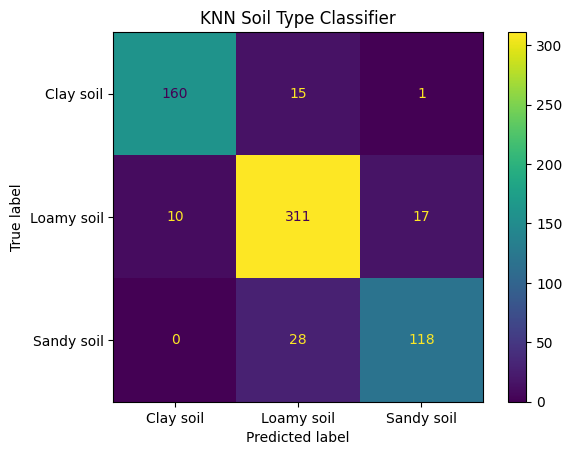

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=6)

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)
# Make predictions on the test set
pred = knn_classifier.predict(X_test)

# Evaluate the accuracy of the KNN classifier
accuracy = metrics.accuracy_score(y_test, pred)
print("Accuracy:", accuracy)
# Calculate macro-averaged precision
macro_precision = metrics.precision_score(y_test, pred, average='macro')

# Calculate macro-averaged recall
macro_recall = metrics.recall_score(y_test, pred, average='macro')

print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
confusion_matrix2 = metrics.confusion_matrix(y_test, pred)

class_labels = sorted(y.unique())

cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels=class_labels)
# cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels=['Clay', 'Loamy', 'Sandy'])
cm_display2.plot()
plt.title('KNN Soil Type Classifier')
plt.show()
# print(pred)

In [17]:
print(pred[:10])
print(y_test[:10])

['Loamy soil' 'Loamy soil' 'Loamy soil' 'Loamy soil' 'Loamy soil'
 'Sandy soil' 'Loamy soil' 'Clay soil' 'Clay soil' 'Clay soil']
1451    Loamy soil
1334    Loamy soil
1761    Loamy soil
1735    Loamy soil
1576    Loamy soil
1110    Sandy soil
1594    Loamy soil
530      Clay soil
651      Clay soil
819      Clay soil
Name: GENERAL_SOIL_TYPE, dtype: object


In [152]:
# save the model
joblib.dump(knn_classifier, './soil_type_prediction_model.pkl')

['./soil_type_prediction_model.pkl']

0.8727272727272727


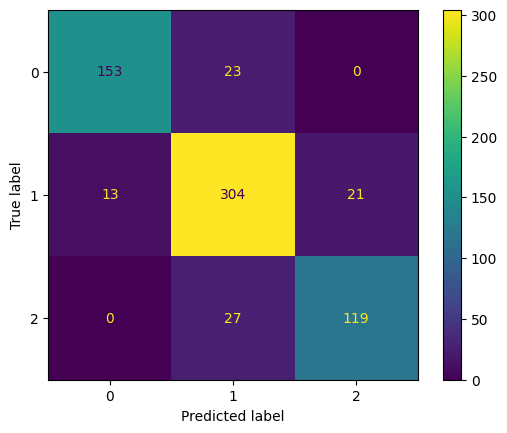

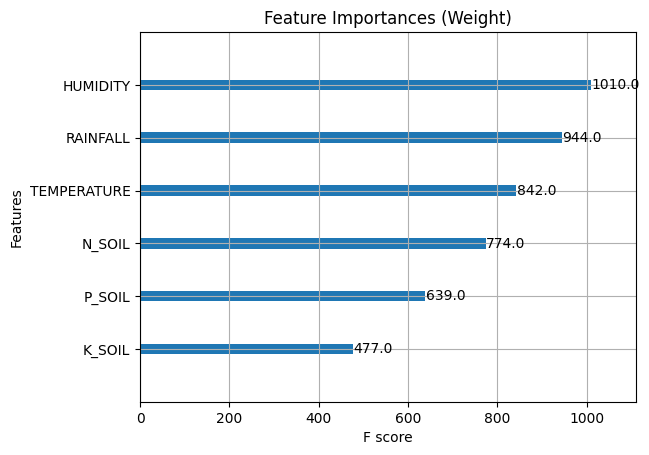

In [130]:
encoder = LabelEncoder()
en_y_train = encoder.fit_transform(y_train)
en_y_test = encoder.fit_transform(y_test)
xgb_classifier3 = XGBClassifier(objective='multi:softmax')

xgb_classifier3.fit(X_train, en_y_train)
pred2 = xgb_classifier3.predict(X_test)
print(metrics.accuracy_score(en_y_test, pred2))
confusion_matrix2 = metrics.confusion_matrix(en_y_test, pred2)

cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2)

cm_display2.plot()
plt.show()
xgb.plot_importance(xgb_classifier3, importance_type='weight', max_num_features=10)
plt.title('Feature Importances (Weight)')
plt.show()


In [137]:
xgb_classifier2 = XGBClassifier()
# Define parameter ranges to tune
param = {
    "n_estimators": stats.randint(100, 200),
    "learning_rate": stats.uniform(0.001, 0.01),
    "max_depth": stats.randint(3, 10),
    "subsample": stats.uniform(0.5, 0.5),
    "gamma": stats.uniform(0, 1),
    "objective": "multi:softmax"
}
# find optimal parameters
search = RandomizedSearchCV(xgb_classifier2, param_distributions=param, n_iter = 10,return_train_score=True)

search.fit(X_train, en_y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028017CF1CF0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028013F09570>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000280111B2170>,
                                        'objective': 'multi:softmax',
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028017CF1FF0>},
                   return_train_score=True)

0.8833333333333333


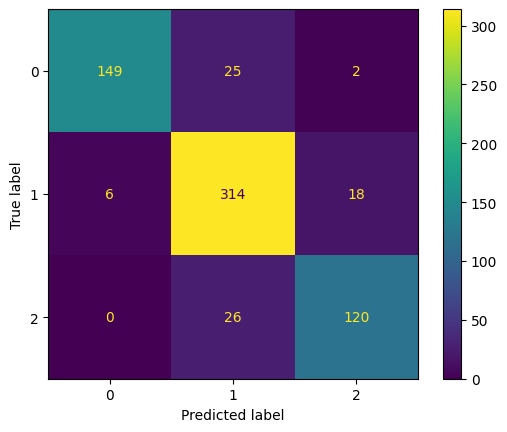

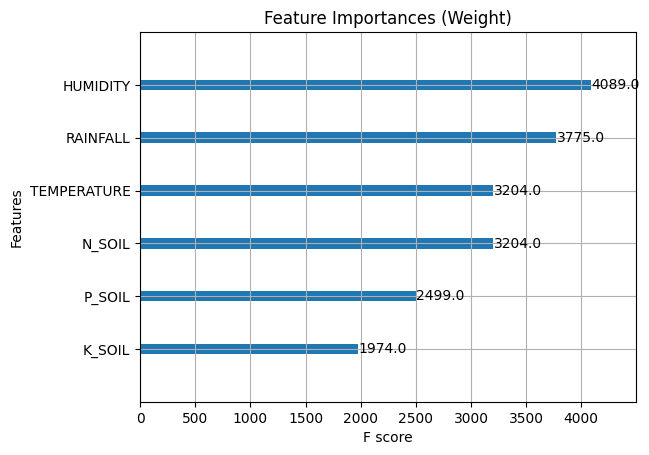

In [138]:
# Get the best estimator from the search
best_xgb_classifier2 = search.best_estimator_

# Set the parameters of the XGBoost classifier to the optimal values
xgb_classifier2.set_params(**best_xgb_classifier2.get_params())

# Fit the classifier on the training data using the optimal parameters
xgb_classifier2.fit(X_train, en_y_train)

pred2 = xgb_classifier2.predict(X_test)
print(metrics.accuracy_score(en_y_test, pred2))
confusion_matrix2 = metrics.confusion_matrix(en_y_test, pred2)

cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2)

cm_display2.plot()
plt.show()
xgb.plot_importance(xgb_classifier2, importance_type='weight', max_num_features=10)
plt.title('Feature Importances (Weight)')
plt.show()

In [140]:
xgb_classifier2.save_model('./xgboost_soil_type_prediction_model.bin')

### KNN classifier performed the best so it will be used for predicting soil type